In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [58]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [59]:
df = pd.read_csv(data)

In [60]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [61]:
df.columns = df.columns.str.lower()

In [62]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [63]:
#prepare the numerical variables:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

In [64]:
#remove clients with unkown default status
df = df[df.status != 'unk'].reset_index(drop = True)

In [65]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [66]:
#What are the categorical variables? What are the numerical?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4454 entries, 0 to 4453
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   seniority  4454 non-null   int64 
 1   home       4454 non-null   object
 2   time       4454 non-null   int64 
 3   age        4454 non-null   int64 
 4   marital    4454 non-null   object
 5   records    4454 non-null   object
 6   job        4454 non-null   object
 7   expenses   4454 non-null   int64 
 8   income     4454 non-null   int64 
 9   assets     4454 non-null   int64 
 10  debt       4454 non-null   int64 
 11  amount     4454 non-null   int64 
 12  price      4454 non-null   int64 
 13  default    4454 non-null   int32 
dtypes: int32(1), int64(9), object(4)
memory usage: 469.9+ KB


In [67]:
numerical = list(df._get_numeric_data().columns)
numerical

['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price',
 'default']

In [68]:
categorical = [x for x in list(df.columns) if x not in numerical]
categorical

['home', 'marital', 'records', 'job']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)

In [71]:
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [72]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [73]:
len(df), len(df_full_train), len(df_train), len(df_test)

(4454, 3563, 2672, 891)

# Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenses'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [74]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

In [75]:
cols = ['seniority', 'time', 'income', 'debt']
minmaxscaler = MinMaxScaler()
df_scaled = minmaxscaler.fit_transform(df_train[cols])

In [76]:
df_scaled[:5,:]

array([[0.25      , 0.27272727, 0.10636079, 0.        ],
       [0.08333333, 0.81818182, 0.14911366, 0.        ],
       [0.        , 0.81818182, 0.3076121 , 0.        ],
       [0.125     , 0.63636364, 0.11887383, 0.        ],
       [0.25      , 0.45454545, 0.        , 0.        ]])

In [77]:
df_scaled = pd.DataFrame(df_scaled, columns = cols)

In [78]:
df_scaled.head()

,seniority,time,income,debt
0,0.250000,0.272727,0.106361,0.0
1,0.083333,0.818182,0.149114,0.0
2,0.000000,0.818182,0.307612,0.0
3,0.125000,0.636364,0.118874,0.0
4,0.250000,0.454545,0.000000,0.0


In [79]:
roc_auc_score(df_train['default'], df_scaled['seniority'])

0.2906221375508058

In [80]:
for col in cols:
    auc_s = roc_auc_score(df_train['default'], df_scaled[col])
    print('For', col, 'the auc score is: ', auc_s)

For seniority the auc score is:  0.2906221375508058
For time the auc score is:  0.5608662489595051
For income the auc score is:  0.31799333386736695
For debt the auc score is:  0.49521703242164505


since for some of the attributes the area under the curve is below 0.5, we should change the direction of the association by adding a (-) to the actual values and do the min max scaling again.

In [81]:
neg_cols = ['seniority', 'income', 'debt']
df_neg_cols = df_train[neg_cols]*(-1)

In [82]:
df_neg_cols.head()

,seniority,income,debt
0,-12,-102,0
1,-4,-143,0
2,0,-295,0
3,-6,-114,0
4,-12,0,0


In [83]:
df_neg_scaled = minmaxscaler.fit_transform(df_neg_cols[neg_cols])
df_neg_scaled = pd.DataFrame(df_neg_scaled, columns = neg_cols)
for col in neg_cols:
    auc_s = roc_auc_score(df_train['default'], df_neg_scaled[col])
    print('For', col, 'the auc score is: ', auc_s)

For seniority the auc score is:  0.7093778624491943
For income the auc score is:  0.682006666132633
For debt the auc score is:  0.5047829675783548


Aparantly, **seniority** has the highest score. 

# Training the model
From now on, use these columns only:

['seniority', 'income', 'assets', 'records', 'job', 'home']

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [84]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [85]:
y_train = df_train['default'].values
y_val = df_val['default'].values
y_test = df_test['default'].values

In [87]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [91]:
dv = DictVectorizer(sparse = False)

train_dict = df_train[features].to_dict(orient = 'record')
val_dict = df_val[features].to_dict(orient = 'record')
test_dict = df_test[features].to_dict(orient = 'record')

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

C:\Users\Ali\AppData\Local\Temp/ipykernel_4228/3105211205.py:3: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  train_dict = df_train[features].to_dict(orient = 'record')
C:\Users\Ali\AppData\Local\Temp/ipykernel_4228/3105211205.py:4: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  val_dict = df_val[features].to_dict(orient = 'record')
C:\Users\Ali\AppData\Local\Temp/ipykernel_4228/3105211205.py:5: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  test_dict = df_test[features].to_dict(orient = 'reco

In [90]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [92]:
y_pred = model.predict_proba(X_val)[:, 1]

In [114]:
print(y_pred[:5])

[0.56012438 0.53831638 0.509534   0.4008453  0.12343333]


In [94]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred).round(3)


0.812

# Question 3
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01

For each threshold, compute precision and recall

Plot them

In [95]:
from sklearn.metrics import precision_recall_curve

In [98]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

In [101]:
precision.shape, recall.shape, thresholds.shape

((854,), (854,), (853,))

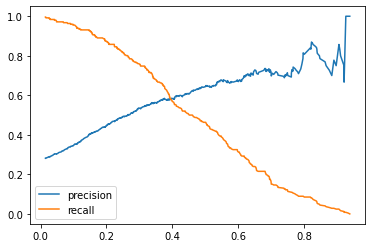

In [102]:
plt.plot(thresholds, precision[1:], label = "precision")
plt.plot(thresholds, recall[1:], label = 'recall')
plt.legend()

0.4

# Question 4
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [103]:
F_one = 2 * (precision * recall) / (precision + recall)

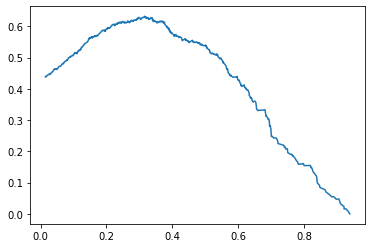

In [104]:
plt.plot(thresholds, F_one[1:])

0.3

# Question 5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: 
* LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

In [105]:
def train(df, y_train):
    dicts = df[features].to_dict(orient = 'records')
    
    div = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [106]:
def predict(df, dv, model):
    dicts = df[features].to_dict(orient = 'records')
    
    X = dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [107]:
from sklearn.model_selection import KFold

In [108]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

In [109]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.default.values
    y_val = df_val.default.values
    
    dv, model = train(df_train, y_train) 
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [110]:
scores

[0.8256212256212256,
 0.8254176350237372,
 0.7893383818254285,
 0.8250108084738436,
 0.8054696294614563]

In [111]:
np.mean(scores), np.std(scores)

(0.8141715360811382, 0.014611424893554475)

0.014

# Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.01, 0.1, 1, 10]
* Initialize KFold with the same parameters as previously
* Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [112]:
def train(df, y_train, C = 1):
    dicts = df[features].to_dict(orient = 'records')
    
    div = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[features].to_dict(orient = 'records')
    
    X = dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [113]:
n_splits = 5

for C in [0.01, 0.1, 1, 10]:
    
    scores = []
    kfold = KFold(n_splits = n_splits, shuffle = True, random_state = 1)

    for train_idx, val_idx in kfold.split(df_full_train):
        
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C = C) 
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('C = %s %.3f +- %.3f' %(C, np.mean(scores), np.std(scores)) )

C = 0.01 0.808 +- 0.012
C = 0.1 0.813 +- 0.014
C = 1 0.814 +- 0.015
C = 10 0.814 +- 0.015


1